In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

%run MobileNetV2.ipynb

2024-04-05 14:31:50.147878: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 14:31:50.201109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 14:31:51.019209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-04-05 14:31:52.656027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


In [3]:
# Konfiguration
image_size = (250, 250)
batch_size = 32

In [4]:
path_with_sign = 'data/y'
path_without_sign = 'data/n'

In [5]:
def load_images_from_folder(folder, label, target_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [6]:
images_with_sign, labels_with_sign = load_images_from_folder(path_with_sign, 1, image_size)
images_without_sign, labels_without_sign = load_images_from_folder(path_without_sign, 0, image_size)

In [7]:
all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

In [8]:
all_images /= 255.0
all_images

array([[[[0.49019608, 0.5019608 , 0.33333334],
         [0.4862745 , 0.5019608 , 0.3647059 ],
         [0.5176471 , 0.53333336, 0.42745098],
         ...,
         [0.53333336, 0.53333336, 0.5254902 ],
         [0.5294118 , 0.5294118 , 0.5294118 ],
         [0.5254902 , 0.5254902 , 0.5176471 ]],

        [[0.43529412, 0.43529412, 0.29411766],
         [0.4392157 , 0.44313726, 0.31764707],
         [0.46666667, 0.4862745 , 0.36862746],
         ...,
         [0.5176471 , 0.5176471 , 0.50980395],
         [0.52156866, 0.52156866, 0.52156866],
         [0.5137255 , 0.5137255 , 0.5058824 ]],

        [[0.45490196, 0.44313726, 0.32156864],
         [0.45882353, 0.45490196, 0.33333334],
         [0.45882353, 0.47058824, 0.34901962],
         ...,
         [0.5137255 , 0.5137255 , 0.5058824 ],
         [0.5019608 , 0.50980395, 0.49019608],
         [0.5058824 , 0.5137255 , 0.49411765]],

        ...,

        [[0.44313726, 0.42745098, 0.41568628],
         [0.48235294, 0.47058824, 0.4509804 ]

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [10]:
train_images.shape, test_images.shape, validation_images.shape

((931, 250, 250, 3), (292, 250, 250, 3), (233, 250, 250, 3))

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [12]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)
validation_generator = test_datagen.flow(validation_images, validation_labels, batch_size=batch_size)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


/home/chandrsangee@edu.local/miniconda3/envs/gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,872,449 (52.92 MB)

 Trainable params: 13,872,449 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_images) // batch_size
)

Epoch 1/100


/home/chandrsangee@edu.local/miniconda3/envs/gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712320320.612644  926770 service.cc:145] XLA service 0x7f4120005720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712320320.612731  926770 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-05 14:32:00.649048: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-05 14:32:00.843348: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN ver

 1/29 ━━━━━━━━━━━━━━━━━━━━ 3:03 7s/step - accuracy: 0.4375 - loss: 0.6956

I0000 00:00:1712320323.664471  926770 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/29 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.4619 - loss: 1.8832

I0000 00:00:1712320330.182750  926771 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 68 bytes spill stores, 68 bytes spill loads



29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.4693 - loss: 1.5900 - val_accuracy: 0.4777 - val_loss: 0.6934
Epoch 2/100
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4375 - loss: 0.6954

2024-04-05 14:32:11.516743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:11.516845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/chandrsangee@edu.local/miniconda3/envs/gpu/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-05 14:32:11.516891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:32:11.516925: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4375 - loss: 0.6954 - val_accuracy: 0.4444 - val_loss: 0.6955
Epoch 3/100


2024-04-05 14:32:12.029240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:12.029347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:32:12.029378: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:32:12.029407: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5326 - loss: 0.6925 - val_accuracy: 0.6295 - val_loss: 0.6811
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6250 - loss: 0.6832 - val_accuracy: 0.3333 - val_loss: 0.7036
Epoch 5/100


2024-04-05 14:32:21.474340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:21.474413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:32:21.474447: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:32:21.474476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:32:21.482730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:21.482792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.5804 - loss: 0.6766 - val_accuracy: 0.6339 - val_loss: 0.6392
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.5938 - loss: 0.6792 - val_accuracy: 0.5556 - val_loss: 0.6808
Epoch 7/100


2024-04-05 14:32:30.951036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:30.951111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:32:30.951143: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:32:30.951171: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:32:30.959626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:30.959688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.5811 - loss: 0.6921 - val_accuracy: 0.4866 - val_loss: 0.7040
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.5938 - loss: 0.6670 - val_accuracy: 0.5556 - val_loss: 0.6610
Epoch 9/100


2024-04-05 14:32:40.525283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:40.525383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:32:40.525425: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:32:40.525455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:32:40.534433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:40.534510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.5149 - loss: 0.6946 - val_accuracy: 0.5357 - val_loss: 0.6777
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5625 - loss: 0.6807 - val_accuracy: 0.4444 - val_loss: 0.7238
Epoch 11/100


2024-04-05 14:32:48.970434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:48.970501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:32:48.970535: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:32:48.970564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:32:48.978427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:48.978488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.5773 - loss: 0.6772 - val_accuracy: 0.6250 - val_loss: 0.6357
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.6250 - loss: 0.6203 - val_accuracy: 0.4444 - val_loss: 0.7509
Epoch 13/100


2024-04-05 14:32:58.253631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:58.253724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:32:58.253767: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:32:58.253819: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:32:58.260994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:32:58.261066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.5786 - loss: 0.6709 - val_accuracy: 0.6518 - val_loss: 0.6237
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.7188 - loss: 0.6108 - val_accuracy: 0.6667 - val_loss: 0.5955
Epoch 15/100


2024-04-05 14:33:07.361648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:07.361725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:33:07.361761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:33:07.361789: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:33:07.369279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:07.369352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.6345 - loss: 0.6602 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 16/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.5000 - loss: 0.6925 - val_accuracy: 0.6667 - val_loss: 0.6728
Epoch 17/100


2024-04-05 14:33:16.752000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:16.752092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:33:16.752135: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:33:16.752167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:33:16.760165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:16.760244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.5425 - loss: 0.6887 - val_accuracy: 0.5312 - val_loss: 0.6897
Epoch 18/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.5312 - loss: 0.7026 - val_accuracy: 0.4444 - val_loss: 0.7202
Epoch 19/100


2024-04-05 14:33:26.109431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:26.109515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:33:26.109561: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:33:26.109592: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:33:26.118940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:26.119015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.6023 - loss: 0.6736 - val_accuracy: 0.6875 - val_loss: 0.6006
Epoch 20/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6250 - loss: 0.7193 - val_accuracy: 0.6667 - val_loss: 0.6198
Epoch 21/100


2024-04-05 14:33:35.578426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:35.578505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:33:35.578538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:33:35.578568: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:33:35.587378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:35.587461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.6204 - loss: 0.6545 - val_accuracy: 0.5714 - val_loss: 0.6842
Epoch 22/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6562 - loss: 0.6530 - val_accuracy: 0.7778 - val_loss: 0.6431
Epoch 23/100


2024-04-05 14:33:44.993663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:44.993753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:33:44.993789: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:33:44.993818: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:33:45.002479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:45.002546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.6641 - loss: 0.6548 - val_accuracy: 0.6741 - val_loss: 0.5970
Epoch 24/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.6250 - loss: 0.6157 - val_accuracy: 0.6667 - val_loss: 0.6353
Epoch 25/100


2024-04-05 14:33:54.435185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:54.435263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:33:54.435295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:33:54.435325: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:33:54.443554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:33:54.443620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.6840 - loss: 0.6082 - val_accuracy: 0.6875 - val_loss: 0.5806
Epoch 26/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.5312 - loss: 0.7015 - val_accuracy: 0.7778 - val_loss: 0.5398
Epoch 27/100


2024-04-05 14:34:03.806873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:03.806958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:34:03.806996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:34:03.807027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:34:03.816189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:03.816271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.6951 - loss: 0.6230 - val_accuracy: 0.6741 - val_loss: 0.5933
Epoch 28/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5625 - loss: 0.6618 - val_accuracy: 0.7778 - val_loss: 0.6226
Epoch 29/100


2024-04-05 14:34:13.293518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:13.293597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:34:13.293633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:34:13.293664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:34:13.301837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:13.301916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.6463 - loss: 0.5997 - val_accuracy: 0.6473 - val_loss: 0.6730
Epoch 30/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.6875 - loss: 0.5831 - val_accuracy: 1.0000 - val_loss: 0.1698
Epoch 31/100


2024-04-05 14:34:22.652129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:22.652254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:34:22.652292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:34:22.652328: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:34:22.661089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:22.661149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.6980 - loss: 0.5747 - val_accuracy: 0.6920 - val_loss: 0.6004
Epoch 32/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.5938 - loss: 0.6157 - val_accuracy: 0.8889 - val_loss: 0.4720
Epoch 33/100


2024-04-05 14:34:32.130094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:32.130167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:34:32.130197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:34:32.130226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:34:32.138162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:32.138224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.6378 - loss: 0.6255 - val_accuracy: 0.6696 - val_loss: 0.6046
Epoch 34/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.6875 - loss: 0.6129 - val_accuracy: 0.7778 - val_loss: 0.5536
Epoch 35/100


2024-04-05 14:34:41.537696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:41.537780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:34:41.537826: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:34:41.537858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:34:41.547536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:41.547602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.6494 - loss: 0.6071 - val_accuracy: 0.6786 - val_loss: 0.6120
Epoch 36/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.6562 - loss: 0.6042 - val_accuracy: 0.7778 - val_loss: 0.5631
Epoch 37/100


2024-04-05 14:34:50.970455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:50.970528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:34:50.970561: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:34:50.970590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:34:50.978739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:34:50.978815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.6877 - loss: 0.5932 - val_accuracy: 0.7098 - val_loss: 0.5452
Epoch 38/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.7500 - loss: 0.5073 - val_accuracy: 0.5556 - val_loss: 0.6527
Epoch 39/100


2024-04-05 14:35:00.333381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:00.333455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:00.333487: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:35:00.333518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:35:00.341465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:00.341529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.6861 - loss: 0.5868 - val_accuracy: 0.7366 - val_loss: 0.5356
Epoch 40/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.5312 - loss: 0.6935 - val_accuracy: 0.8889 - val_loss: 0.4452
Epoch 41/100


2024-04-05 14:35:09.850826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:09.850910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:09.850943: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:35:09.850972: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:35:09.858719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:09.858778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.6958 - loss: 0.5556 - val_accuracy: 0.6607 - val_loss: 0.6079
Epoch 42/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.6875 - loss: 0.5376 - val_accuracy: 0.5556 - val_loss: 0.5491
Epoch 43/100


2024-04-05 14:35:19.201916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:19.201968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:19.201986: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:35:19.202003: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:35:19.212366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:19.212452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.6854 - loss: 0.5854 - val_accuracy: 0.7500 - val_loss: 0.5219
Epoch 44/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.8438 - loss: 0.4719 - val_accuracy: 0.5556 - val_loss: 0.5949
Epoch 45/100


2024-04-05 14:35:28.725549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:28.725633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:28.725671: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:35:28.725701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:35:28.734499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:28.734564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.6840 - loss: 0.5742 - val_accuracy: 0.6384 - val_loss: 0.6440
Epoch 46/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.7500 - loss: 0.5352 - val_accuracy: 0.4444 - val_loss: 0.8041
Epoch 47/100


2024-04-05 14:35:38.298916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:38.298990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:38.299023: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:35:38.299055: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:35:38.306663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:38.306736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.7247 - loss: 0.5665 - val_accuracy: 0.7009 - val_loss: 0.5459
Epoch 48/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.7500 - loss: 0.4763 - val_accuracy: 0.7778 - val_loss: 0.5426
Epoch 49/100


2024-04-05 14:35:46.164035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:46.164075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:46.171942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:46.171999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:46.172028: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:35:46.172055: I tensorflow/core/framework/local_re

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7532 - loss: 0.5357 - val_accuracy: 0.7098 - val_loss: 0.5657
Epoch 50/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.6250 - loss: 0.5824 - val_accuracy: 1.0000 - val_loss: 0.3863
Epoch 51/100


2024-04-05 14:35:55.559820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:55.559871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:55.567913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:35:55.567976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:35:55.568005: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:35:55.568033: I tensorflow/core/framework/local_re

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.6709 - loss: 0.5813 - val_accuracy: 0.7411 - val_loss: 0.5291
Epoch 52/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.6562 - loss: 0.6208 - val_accuracy: 0.8889 - val_loss: 0.3341
Epoch 53/100


2024-04-05 14:36:04.935786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:04.935870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:36:04.935914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:36:04.935945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:36:04.944264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:04.944330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.7025 - loss: 0.5581 - val_accuracy: 0.7188 - val_loss: 0.5498
Epoch 54/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.7500 - loss: 0.5281 - val_accuracy: 1.0000 - val_loss: 0.2282
Epoch 55/100


2024-04-05 14:36:14.442114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:14.442158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:36:14.442175: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:36:14.442194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:36:14.450737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:14.450814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.7065 - loss: 0.5433 - val_accuracy: 0.7500 - val_loss: 0.5339
Epoch 56/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7188 - loss: 0.4954 - val_accuracy: 0.6667 - val_loss: 0.5921
Epoch 57/100


2024-04-05 14:36:23.835708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:23.835788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:36:23.835819: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:36:23.835850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:36:23.844321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:23.844383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.6613 - loss: 0.5890 - val_accuracy: 0.7366 - val_loss: 0.5241
Epoch 58/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.6875 - loss: 0.5254 - val_accuracy: 0.6667 - val_loss: 0.5410
Epoch 59/100


2024-04-05 14:36:33.260744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:33.260838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:36:33.260875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:36:33.260906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:36:33.268937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:33.268998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.7133 - loss: 0.5618 - val_accuracy: 0.6964 - val_loss: 0.5882
Epoch 60/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6562 - loss: 0.5776 - val_accuracy: 0.5556 - val_loss: 0.5241
Epoch 61/100


2024-04-05 14:36:42.660538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:42.660612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:36:42.660643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:36:42.660673: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:36:42.668331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:42.668395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.7528 - loss: 0.5199 - val_accuracy: 0.7679 - val_loss: 0.5111
Epoch 62/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.8125 - loss: 0.4890 - val_accuracy: 0.7778 - val_loss: 0.4993
Epoch 63/100


2024-04-05 14:36:51.994123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:51.994196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:36:51.994229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:36:51.994259: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:36:52.003155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:36:52.003220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.7424 - loss: 0.5224 - val_accuracy: 0.6429 - val_loss: 0.6056
Epoch 64/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5938 - loss: 0.6670 - val_accuracy: 0.7778 - val_loss: 0.4819
Epoch 65/100


2024-04-05 14:37:01.625979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:01.626031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:01.634823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:01.634882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:01.634924: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:37:01.634951: I tensorflow/core/framework/local_re

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.6757 - loss: 0.5822 - val_accuracy: 0.7679 - val_loss: 0.4694
Epoch 66/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.6250 - loss: 0.6086 - val_accuracy: 0.7778 - val_loss: 0.4066
Epoch 67/100


2024-04-05 14:37:09.571567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:09.571644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:09.571690: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:37:09.571731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:37:09.578986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:09.579059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.7009 - loss: 0.5786 - val_accuracy: 0.6875 - val_loss: 0.5765
Epoch 68/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.6875 - loss: 0.6119 - val_accuracy: 0.6667 - val_loss: 0.6185
Epoch 69/100


2024-04-05 14:37:18.987420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:18.987477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:18.995873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:18.995937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:18.995969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:37:18.995997: I tensorflow/core/framework/local_re

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.7061 - loss: 0.5638 - val_accuracy: 0.6741 - val_loss: 0.5604
Epoch 70/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.6875 - loss: 0.6130 - val_accuracy: 0.7778 - val_loss: 0.4005
Epoch 71/100


2024-04-05 14:37:28.533355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:28.533460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:28.533510: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:37:28.533554: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:37:28.540543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:28.540600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.7238 - loss: 0.5333 - val_accuracy: 0.7679 - val_loss: 0.4778
Epoch 72/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.7500 - loss: 0.4171 - val_accuracy: 0.7778 - val_loss: 0.3780
Epoch 73/100


2024-04-05 14:37:38.085705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:38.085746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:38.085763: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:37:38.085778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:37:38.094043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:38.094106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.7188 - loss: 0.5379 - val_accuracy: 0.7098 - val_loss: 0.5510
Epoch 74/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.6667 - loss: 0.6707 - val_accuracy: 0.7778 - val_loss: 0.5226
Epoch 75/100


2024-04-05 14:37:47.520326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:47.520389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:47.520415: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:37:47.520438: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:37:47.528325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:47.528390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7291 - loss: 0.5365 - val_accuracy: 0.7321 - val_loss: 0.5203
Epoch 76/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.5938 - loss: 0.6974 - val_accuracy: 1.0000 - val_loss: 0.3135
Epoch 77/100


2024-04-05 14:37:56.989191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:56.989246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:56.998589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:37:56.998654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:37:56.998685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:37:56.998713: I tensorflow/core/framework/local_re

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.7105 - loss: 0.5796 - val_accuracy: 0.7277 - val_loss: 0.5407
Epoch 78/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.6875 - loss: 0.5886 - val_accuracy: 0.6667 - val_loss: 0.5136
Epoch 79/100


2024-04-05 14:38:06.514681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:06.514733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:38:06.522566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:06.522638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:38:06.522671: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:38:06.522698: I tensorflow/core/framework/local_re

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.7121 - loss: 0.5731 - val_accuracy: 0.6295 - val_loss: 0.6083
Epoch 80/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.7188 - loss: 0.5843 - val_accuracy: 0.6667 - val_loss: 0.5855
Epoch 81/100


2024-04-05 14:38:15.881996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:15.882041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:38:15.882059: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:38:15.882073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:38:15.890360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:15.890420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.7224 - loss: 0.5581 - val_accuracy: 0.7946 - val_loss: 0.4732
Epoch 82/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.7500 - loss: 0.4847 - val_accuracy: 0.7778 - val_loss: 0.4405
Epoch 83/100


2024-04-05 14:38:25.432488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:25.432538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:38:25.432557: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:38:25.432567: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:38:25.442110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:25.442177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.7701 - loss: 0.4906 - val_accuracy: 0.7768 - val_loss: 0.4773
Epoch 84/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.6875 - loss: 0.5720 - val_accuracy: 0.5556 - val_loss: 0.6364
Epoch 85/100


2024-04-05 14:38:34.698982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:34.699058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:38:34.699089: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:38:34.699118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:38:34.706681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:34.706743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.7557 - loss: 0.4959 - val_accuracy: 0.7723 - val_loss: 0.4693
Epoch 86/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.8125 - loss: 0.4400 - val_accuracy: 0.8889 - val_loss: 0.2441
Epoch 87/100


2024-04-05 14:38:43.941048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:43.941130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:38:43.941170: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:38:43.941202: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:38:43.949483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:43.949547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.7558 - loss: 0.5188 - val_accuracy: 0.7411 - val_loss: 0.5037
Epoch 88/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.8125 - loss: 0.4817 - val_accuracy: 1.0000 - val_loss: 0.2697
Epoch 89/100


2024-04-05 14:38:53.513961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:53.514043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:38:53.514076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:38:53.514105: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:38:53.522220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:38:53.522298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.7752 - loss: 0.4814 - val_accuracy: 0.7768 - val_loss: 0.4893
Epoch 90/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7500 - loss: 0.5327 - val_accuracy: 0.7778 - val_loss: 0.4914
Epoch 91/100


2024-04-05 14:39:03.016109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:03.016226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:39:03.016265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:39:03.016295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:39:03.024402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:03.024431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.7594 - loss: 0.5135 - val_accuracy: 0.7946 - val_loss: 0.4781
Epoch 92/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.5938 - loss: 0.7523 - val_accuracy: 0.7778 - val_loss: 0.5962
Epoch 93/100


2024-04-05 14:39:12.515507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:12.515596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:39:12.515633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:39:12.515662: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:39:12.524253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:12.524317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7472 - loss: 0.5248 - val_accuracy: 0.7857 - val_loss: 0.4829
Epoch 94/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6875 - loss: 0.5706 - val_accuracy: 0.8889 - val_loss: 0.3986
Epoch 95/100


2024-04-05 14:39:22.030559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:22.030651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-05 14:39:22.030704: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:39:22.039356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:22.039444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:39:22.039475: I tensorflow/core/framework/local_re

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.7419 - loss: 0.5089 - val_accuracy: 0.7232 - val_loss: 0.5814
Epoch 96/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7500 - loss: 0.4993 - val_accuracy: 0.7778 - val_loss: 0.3987
Epoch 97/100


2024-04-05 14:39:32.269931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:32.270007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:39:32.270046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:39:32.270080: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:39:32.276653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:32.276711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.7668 - loss: 0.4949 - val_accuracy: 0.7857 - val_loss: 0.4855
Epoch 98/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7812 - loss: 0.5627 - val_accuracy: 0.5556 - val_loss: 0.7629
Epoch 99/100


2024-04-05 14:39:42.188497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:42.188578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:39:42.188613: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:39:42.188641: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:39:42.200046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:42.200105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.7400 - loss: 0.5329 - val_accuracy: 0.7946 - val_loss: 0.4604
Epoch 100/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.7188 - loss: 0.5420 - val_accuracy: 0.7778 - val_loss: 0.4650


2024-04-05 14:39:52.243866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:52.243908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-05 14:39:52.243922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16551352623056287982
2024-04-05 14:39:52.243934: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1290930878589058502
2024-04-05 14:39:52.251493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-05 14:39:52.251531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

In [17]:
# Modell evaluieren
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7966 - loss: 0.4766
Testgenauigkeit: 0.7945, Testverlust: 0.4738


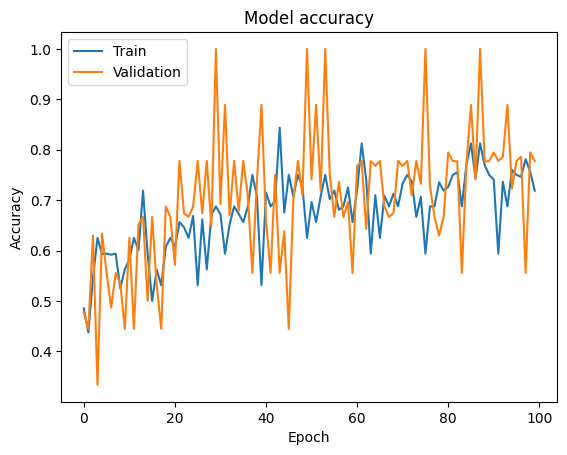

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       145
           1       0.78      0.82      0.80       147

    accuracy                           0.79       292
   macro avg       0.80      0.79      0.79       292
weighted avg       0.80      0.79      0.79       292



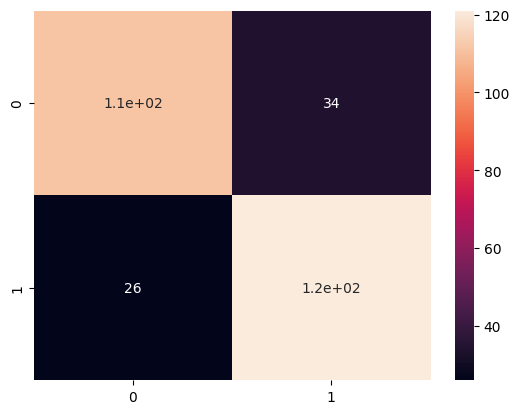

In [19]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

print(classification_report(test_labels, predictions))

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

plt.show()